In [1]:
import torch
import argparse
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class SEM_block_1(nn.Module):
    """
    SEM_block_1
    """

    def __init__(self, ch_1, ch_2, ch_3, ch_4, ch_5):
        super(SEM_block_1, self).__init__()
        self.n_channels = ch_1     # output channels
        
        self.W_2 = nn.Sequential(
            nn.Conv2d(ch_2, ch_1, 3, padding=1),
            # nn.BatchNorm2d(ch_1),
            # nn.ReLU(inplace=True),
        )
        
        self.W_3 = nn.Sequential(
            nn.Conv2d(ch_3, ch_1, 3, padding=1),
            # nn.BatchNorm2d(ch_1),
            # nn.ReLU(inplace=True),
        )

        self.W_4 = nn.Sequential(
            nn.Conv2d(ch_4, ch_1, 3, padding=1),
            # nn.BatchNorm2d(ch_1),
            # nn.ReLU(inplace=True),
        )

        self.W_5 = nn.Sequential(
            nn.Conv2d(ch_5, ch_1, 3, padding=1),
            # nn.BatchNorm2d(ch_1),
            # nn.ReLU(inplace=True),
        )

    def forward(self, layer1, layer2, layer3, layer4, layer5):
        conv2 = self.W_2(layer2)
        conv3 = self.W_3(layer3)
        conv4 = self.W_4(layer4)
        conv5 = self.W_5(layer5)
        w_2 = torch.nn.functional.interpolate(conv2, size = (layer1.shape[2], layer1.shape[3]), mode='bilinear', align_corners=False)
        w_3 = torch.nn.functional.interpolate(conv3, size = (layer1.shape[2], layer1.shape[3]), mode='bilinear', align_corners=False)
        w_4 = torch.nn.functional.interpolate(conv4, size = (layer1.shape[2], layer1.shape[3]), mode='bilinear', align_corners=False)
        w_5 = torch.nn.functional.interpolate(conv5, size = (layer1.shape[2], layer1.shape[3]), mode='bilinear', align_corners=False)

        output = layer1 * w_2 * w_3 * w_4 * w_5
        return output

In [5]:
class SEM_block_2(nn.Module):
    """
    SEM_block_2
    """

    def __init__(self, ch_2, ch_3, ch_4, ch_5):
        super(SEM_block_2, self).__init__()
        self.n_channels = ch_2     # output channels

        self.W_3 = nn.Sequential(
            nn.Conv2d(ch_3, ch_2, 3, padding=1),
            # nn.BatchNorm2d(ch_2),
            # nn.ReLU(inplace=True),
        )

        self.W_4 = nn.Sequential(
            nn.Conv2d(ch_4, ch_2, 3, padding=1),
            # nn.BatchNorm2d(ch_2),
            # nn.ReLU(inplace=True),
        )

        self.W_5 = nn.Sequential(
            nn.Conv2d(ch_5, ch_2, 3, padding=1),
            # nn.BatchNorm2d(ch_2),
            # nn.ReLU(inplace=True),
        )

    def forward(self, layer2, layer3, layer4, layer5):
        conv3 = self.W_3(layer3)
        conv4 = self.W_4(layer4)
        conv5 = self.W_5(layer5)
        w_3 = torch.nn.functional.interpolate(conv3, size = (layer2.shape[2], layer2.shape[3]), mode='bilinear', align_corners=False)
        w_4 = torch.nn.functional.interpolate(conv4, size = (layer2.shape[2], layer2.shape[3]), mode='bilinear', align_corners=False)
        w_5 = torch.nn.functional.interpolate(conv5, size = (layer2.shape[2], layer2.shape[3]), mode='bilinear', align_corners=False)

        output = layer2 * w_3 * w_4 * w_5
        return output

In [6]:
class SEM_block_3(nn.Module):
    """
    SEM_block_3
    """

    def __init__(self, ch_3, ch_4, ch_5):
        super(SEM_block_3, self).__init__()
        self.n_channels = ch_3     # output channels

        self.W_4 = nn.Sequential(
            nn.Conv2d(ch_4, ch_3, 3, padding=1),
            # nn.BatchNorm2d(ch_3),
            # nn.ReLU(inplace=True),
        )

        self.W_5 = nn.Sequential(
            nn.Conv2d(ch_5, ch_3, 3, padding=1),
            # nn.BatchNorm2d(ch_3),
            # nn.ReLU(inplace=True),
        )


    def forward(self, layer3, layer4, layer5):
        conv4 = self.W_4(layer4)
        conv5 = self.W_5(layer5)
        w_4 = torch.nn.functional.interpolate(conv4, size = (layer3.shape[2], layer3.shape[3]), mode='bilinear', align_corners=False)
        w_5 = torch.nn.functional.interpolate(conv5, size = (layer3.shape[2], layer3.shape[3]), mode='bilinear', align_corners=False)

        output = layer3 * w_4 * w_5
        return output

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class SEM_Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(SEM_Unet, self).__init__()
        self.n_channels = in_ch
        self.n_classes = out_ch
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        
        self.SEM1 = SEM_block_1(64, 128, 256, 512, 1024)
        self.SEM2 = SEM_block_2(128, 256, 512, 1024)
        self.SEM3 = SEM_block_3(256, 512, 1024)
        
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        
        sem1 = self.SEM1(c1, c2, c3, c4, c5)
        sem2 = self.SEM2(c2, c3, c4, c5)
        sem3 = self.SEM3(c3, c4, c5)
        
        up_6= self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6=self.conv6(merge6)
        up_7=self.up7(c6)
        merge7 = torch.cat([up_7, sem3], dim=1)
        c7=self.conv7(merge7)
        up_8=self.up8(c7)
        merge8 = torch.cat([up_8, sem2], dim=1)
        c8=self.conv8(merge8)
        up_9=self.up9(c8)
        merge9=torch.cat([up_9, sem1],dim=1)
        c9=self.conv9(merge9)
        c10=self.conv10(c9)
        #out = nn.Sigmoid()(c10)
        return c10

In [8]:
def make_dataset(root):
    imgs=[]
    n=len(os.listdir(root))//2
    for i in range(n):
        img=os.path.join(root,"%03d.png"%i)
        mask=os.path.join(root,"%03d_mask.png"%i)
        imgs.append((img,mask))
    return imgs


class LiverDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x_path, y_path = self.imgs[index]
        img_x = Image.open(x_path)
        img_y = Image.open(y_path)
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y

    def __len__(self):
        return len(self.imgs)

In [9]:
x_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

y_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
])

In [10]:
def train_model(model, criterion, optimizer, dataload, num_epochs=20):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [11]:
model = SEM_Unet(3, 1).to(device)
batch_size = 1
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
liver_dataset = LiverDataset("u_net_liver/data/data/train",transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_model(model, criterion, optimizer, dataloaders, num_epochs=4)

Epoch 0/3
----------
1/400,train_loss:0.642
2/400,train_loss:0.657
3/400,train_loss:0.645
4/400,train_loss:0.642
5/400,train_loss:0.643
6/400,train_loss:0.645
7/400,train_loss:0.635
8/400,train_loss:0.622
9/400,train_loss:0.637
10/400,train_loss:0.616
11/400,train_loss:0.635
12/400,train_loss:0.610
13/400,train_loss:0.620
14/400,train_loss:0.608
15/400,train_loss:0.615
16/400,train_loss:0.607
17/400,train_loss:0.590
18/400,train_loss:0.565
19/400,train_loss:0.546
20/400,train_loss:0.530
21/400,train_loss:0.522
22/400,train_loss:0.512
23/400,train_loss:0.495
24/400,train_loss:0.477
25/400,train_loss:0.467
26/400,train_loss:0.455
27/400,train_loss:0.444
28/400,train_loss:0.413
29/400,train_loss:0.440
30/400,train_loss:0.417
31/400,train_loss:0.398
32/400,train_loss:0.375
33/400,train_loss:0.395
34/400,train_loss:0.349
35/400,train_loss:0.337
36/400,train_loss:0.329
37/400,train_loss:0.317
38/400,train_loss:0.314
39/400,train_loss:0.301
40/400,train_loss:0.334
41/400,train_loss:0.349
42/4

333/400,train_loss:0.026
334/400,train_loss:0.029
335/400,train_loss:0.041
336/400,train_loss:0.017
337/400,train_loss:0.020
338/400,train_loss:0.032
339/400,train_loss:0.038
340/400,train_loss:0.026
341/400,train_loss:0.026
342/400,train_loss:0.018
343/400,train_loss:0.034
344/400,train_loss:0.028
345/400,train_loss:0.025
346/400,train_loss:0.030
347/400,train_loss:0.028
348/400,train_loss:0.033
349/400,train_loss:0.037
350/400,train_loss:0.026
351/400,train_loss:0.029
352/400,train_loss:0.025
353/400,train_loss:0.031
354/400,train_loss:0.022
355/400,train_loss:0.031
356/400,train_loss:0.028
357/400,train_loss:0.030
358/400,train_loss:0.023
359/400,train_loss:0.015
360/400,train_loss:0.029
361/400,train_loss:0.032
362/400,train_loss:0.025
363/400,train_loss:0.032
364/400,train_loss:0.029
365/400,train_loss:0.041
366/400,train_loss:0.015
367/400,train_loss:0.025
368/400,train_loss:0.027
369/400,train_loss:0.030
370/400,train_loss:0.022
371/400,train_loss:0.024
372/400,train_loss:0.019


264/400,train_loss:0.018
265/400,train_loss:0.009
266/400,train_loss:0.016
267/400,train_loss:0.024
268/400,train_loss:0.021
269/400,train_loss:0.008
270/400,train_loss:0.007
271/400,train_loss:0.012
272/400,train_loss:0.011
273/400,train_loss:0.018
274/400,train_loss:0.017
275/400,train_loss:0.014
276/400,train_loss:0.009
277/400,train_loss:0.011
278/400,train_loss:0.008
279/400,train_loss:0.024
280/400,train_loss:0.018
281/400,train_loss:0.023
282/400,train_loss:0.021
283/400,train_loss:0.012
284/400,train_loss:0.010
285/400,train_loss:0.037
286/400,train_loss:0.023
287/400,train_loss:0.018
288/400,train_loss:0.017
289/400,train_loss:0.019
290/400,train_loss:0.024
291/400,train_loss:0.018
292/400,train_loss:0.019
293/400,train_loss:0.020
294/400,train_loss:0.017
295/400,train_loss:0.014
296/400,train_loss:0.024
297/400,train_loss:0.010
298/400,train_loss:0.018
299/400,train_loss:0.013
300/400,train_loss:0.019
301/400,train_loss:0.015
302/400,train_loss:0.008
303/400,train_loss:0.021


195/400,train_loss:0.018
196/400,train_loss:0.022
197/400,train_loss:0.006
198/400,train_loss:0.007
199/400,train_loss:0.011
200/400,train_loss:0.007
201/400,train_loss:0.014
202/400,train_loss:0.025
203/400,train_loss:0.017
204/400,train_loss:0.023
205/400,train_loss:0.011
206/400,train_loss:0.010
207/400,train_loss:0.007
208/400,train_loss:0.021
209/400,train_loss:0.015
210/400,train_loss:0.018
211/400,train_loss:0.019
212/400,train_loss:0.020
213/400,train_loss:0.019
214/400,train_loss:0.014
215/400,train_loss:0.013
216/400,train_loss:0.017
217/400,train_loss:0.015
218/400,train_loss:0.008
219/400,train_loss:0.008
220/400,train_loss:0.029
221/400,train_loss:0.020
222/400,train_loss:0.022
223/400,train_loss:0.022
224/400,train_loss:0.006
225/400,train_loss:0.013
226/400,train_loss:0.007
227/400,train_loss:0.023
228/400,train_loss:0.010
229/400,train_loss:0.017
230/400,train_loss:0.017
231/400,train_loss:0.011
232/400,train_loss:0.013
233/400,train_loss:0.015
234/400,train_loss:0.021


126/400,train_loss:0.006
127/400,train_loss:0.011
128/400,train_loss:0.016
129/400,train_loss:0.014
130/400,train_loss:0.005
131/400,train_loss:0.017
132/400,train_loss:0.012
133/400,train_loss:0.012
134/400,train_loss:0.009
135/400,train_loss:0.007
136/400,train_loss:0.007
137/400,train_loss:0.006
138/400,train_loss:0.015
139/400,train_loss:0.004
140/400,train_loss:0.014
141/400,train_loss:0.009
142/400,train_loss:0.014
143/400,train_loss:0.010
144/400,train_loss:0.011
145/400,train_loss:0.004
146/400,train_loss:0.013
147/400,train_loss:0.006
148/400,train_loss:0.010
149/400,train_loss:0.012
150/400,train_loss:0.017
151/400,train_loss:0.014
152/400,train_loss:0.012
153/400,train_loss:0.014
154/400,train_loss:0.005
155/400,train_loss:0.011
156/400,train_loss:0.011
157/400,train_loss:0.015
158/400,train_loss:0.005
159/400,train_loss:0.010
160/400,train_loss:0.008
161/400,train_loss:0.009
162/400,train_loss:0.094
163/400,train_loss:0.005
164/400,train_loss:0.019
165/400,train_loss:0.050


SEM_Unet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool2): Max

In [12]:
model = model.cpu()

In [13]:
liver_dataset = LiverDataset("u_net_liver/data/data/val", transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=1)
# model.eval()

In [14]:
model.eval()

SEM_Unet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool2): Max

In [15]:
def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    import numpy as np
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    return np.sum(intersection) / np.sum(union)

In [17]:
IoU = 0
n = 0
with torch.no_grad():
    for x, target in dataloaders:
        n = n + 1
        y = model(x)
        y_pred = torch.squeeze(y).numpy() > 0.2
        y_true = torch.squeeze(target).numpy()
        print(meanIOU_per_image(y_pred, y_true))
        IoU = IoU + meanIOU_per_image(y_pred, y_true)
print(IoU/n)

0.8666393106278211
0.8467663081435954
0.8371991881704842
0.836209506509234
0.8196823419495485
0.8198697068403908
0.8058252427184466
0.7681335884501652
0.7176757982900017
0.706966457795798
0.6887531029215199
0.6896199427870863
0.6853024677877266
0.6720092915214867
0.6763580719204285
0.653021978021978
0.6415036674816625
0.6171093480510521
0.5741590214067278
0.5577096483318305
0.7240256994863493


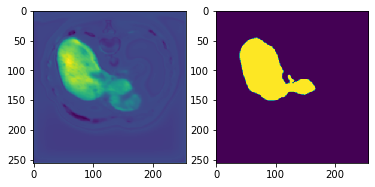

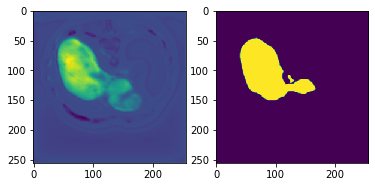

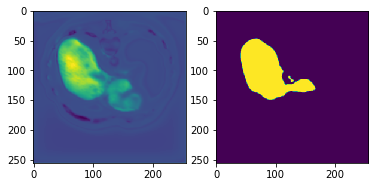

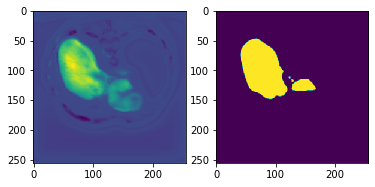

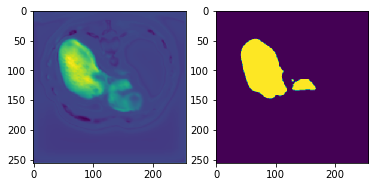

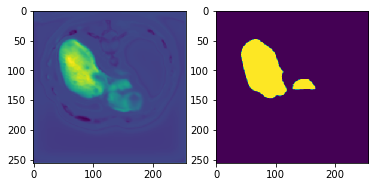

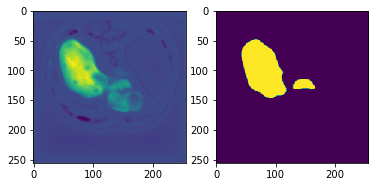

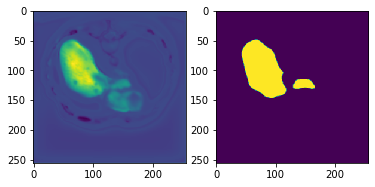

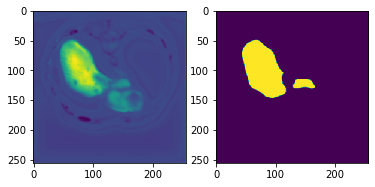

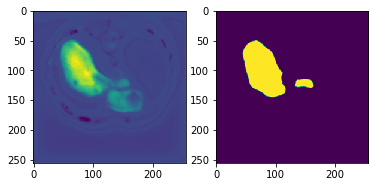

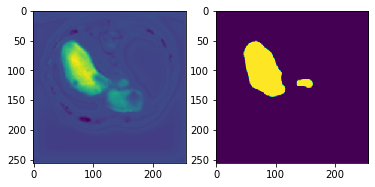

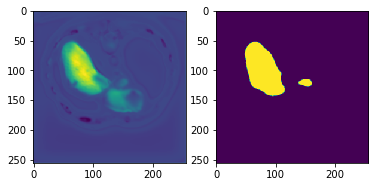

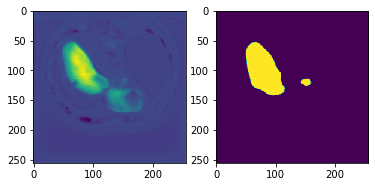

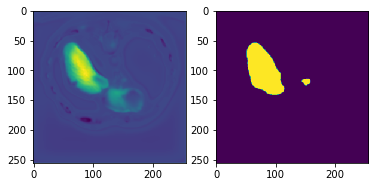

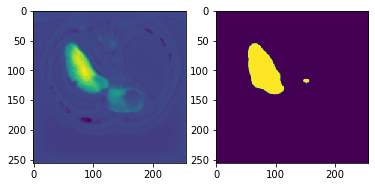

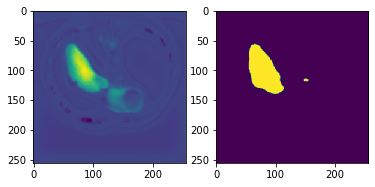

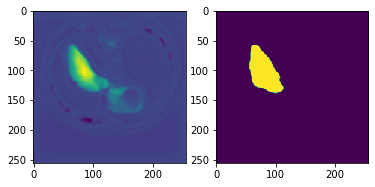

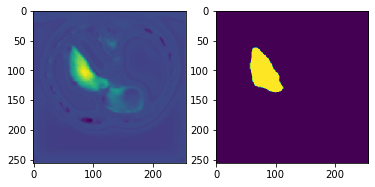

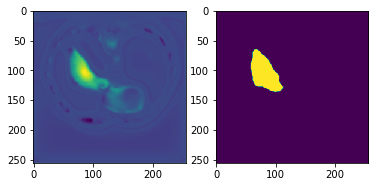

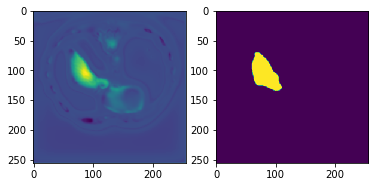

In [18]:
plt.ion()
with torch.no_grad():
    for x,label in dataloaders:
        y=model(x)
        img_y=torch.squeeze(y).numpy()
        img_label = torch.squeeze(label).numpy()  
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(img_y)
        plt.subplot(1,2,2)
        plt.imshow(img_label)
        plt.pause(0.01)
    plt.show()